In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

import util, constants, draw, cam

np.random.seed(0)
torch.manual_seed(0)

from tqdm.notebook import tqdm

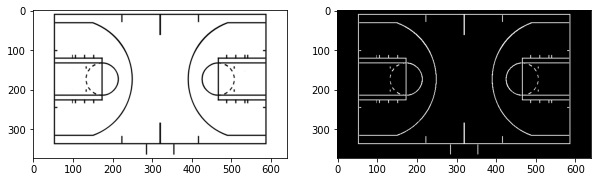

In [2]:
img = plt.imread('/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/court.png')
gray = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
binary = gray<0.1
plt.figure(figsize=(10,3))
plt.subplot(121);plt.imshow(img)
plt.subplot(122);plt.imshow(binary, cmap='gray')
plt.show()

In [3]:
scale = binary.shape[0]
y = (np.arange(binary.shape[0]))
x = (np.arange(binary.shape[1]))
y, x = np.meshgrid(y, x, indexing='ij')
y, x = y[binary], x[binary]
z = np.zeros_like(x)

X_court, Y_court = x, y

x =  (x- binary.shape[1]/2.)/scale
y =  (y- binary.shape[0]/2.)/scale

X_w = torch.from_numpy(np.stack([x,y,z], axis=-1)).float()



In [4]:
gray = binary.astype(np.uint8)*255

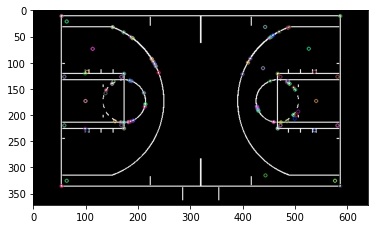

In [5]:
sift = cv2.SIFT_create()
kp = sift.detect(gray, None)
temp = gray.copy()
temp = cv2.drawKeypoints(temp,kp,img)
plt.imshow(temp)

# Convention Used
## World Coordinates
-Z is direction of gravity.
# Camera Coordinates
+Z is looking forward.
+X is looking left.
+Y is looking up.


We know that $x_i = x_cfm_x/z_c + u_0$.
We instead define $(f_x, f_y) = f(m_x, m_y)$.

We will let $u_0=v_0=0$

We will crop the image in $x$ and $y$ at $(-1, 1)$ and the $f_x, f_y$ will determine how "fast or slow" the x coordinate will grow and shrink and adjust to our cropping window.
We will display the cropping window with whatever height x width we want to.

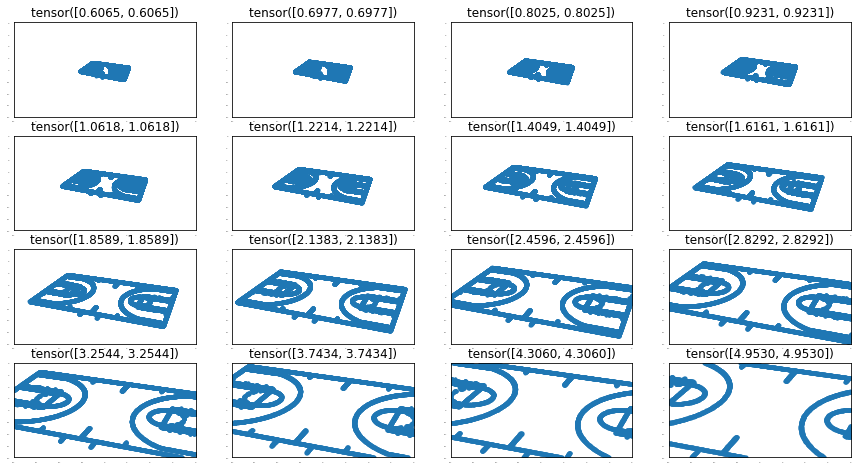

In [6]:
plt.figure(figsize=(15, 8))
r = 1.+.05*torch.randn(1)[0]
theta = torch.rand(1)[0]*2*np.pi
x,y  = r*torch.cos(theta), r*torch.sin(theta)
z = 1.5+.2*torch.randn(1)[0].abs()

for i in range(16):
    plt.subplot(4, 4, i+1)
    dofs_f = torch.linspace(-0.5, 1.6, 16)[i]
    dofs_f = torch.stack([dofs_f, torch.tensor(0.)])
    dofs_cam = cam.calc_dofs_cam(torch.tensor([x, y, z]), torch.tensor([0.001,0.001,0.001]), dofs_f)
    draw.show_cam_view(X_w, dofs_cam, calc_fxy=cam.calc_fxy_ratio)
    plt.title(cam.calc_fxy_ratio(dofs_f))


In [7]:
# def generate_random_views(*shape):
#     r = 1+.2*torch.randn(shape)
#     theta = torch.rand(shape)*2*np.pi
#     x,y  = r*torch.cos(theta), r*torch.sin(theta)
#     z = 0.3+1.*torch.randn(shape).abs()
#     dofs_f = (torch.rand(*shape, 2)*(1.6--0.5) - 0.5)
#     x = torch.stack([x,y,z], dim=-1)
#     pts_to = 0.3*torch.randn_like(x)
    
#     dofs_cam = cam.calc_dofs_cam(x,pts_to, dofs_f)
#     return dofs_cam, pts_to

# X sould be of shape (..., 8) and be from a standard multivariate gaussian
def gaussian2cam(X):
    r = .4+.8*torch.sigmoid(X[..., 0])
    theta = 2*np.pi*X[..., 1]
    z = .1+.3*X[..., 2].abs()
    x, y = r*torch.cos(theta), r*torch.sin(theta)
    pos = torch.stack([x,y,z], dim=-1)
    
    px, py, pz = .4+.2*X[..., 3], .2*X[..., 4], .1*X[..., 5].abs()
    pts_to = torch.stack([px, py, pz], dim=-1)
    
    
    logfx = 0.3*X[..., [6]]
#     logfyfx = .3*X[..., [7]]
    logfyfx = -.2+.2*X[..., [7]]
    
    dofs_f = torch.cat([logfx, logfyfx], dim=-1)
    
    dofs_cam = cam.calc_dofs_cam(pos, pts_to, dofs_f)
    
    return dofs_cam, pts_to

In [8]:
views_court = [[0,0], [90, 0], [25, 45]]
region_court = [[-.7,.7], [-.7, .7], [0, .7]]

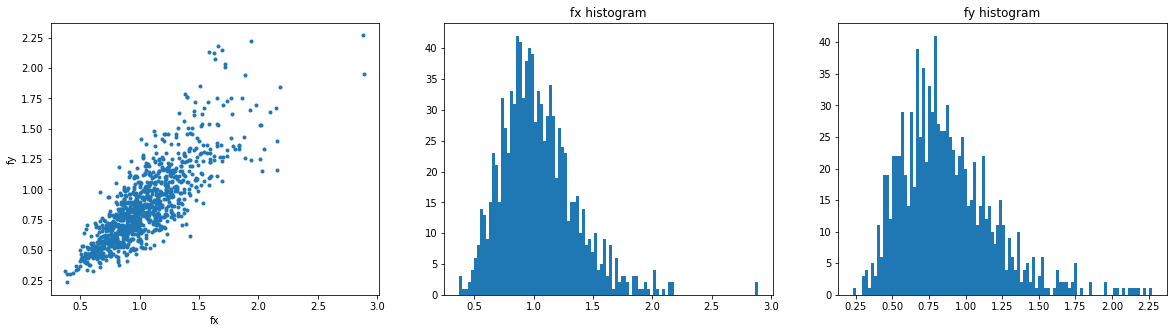

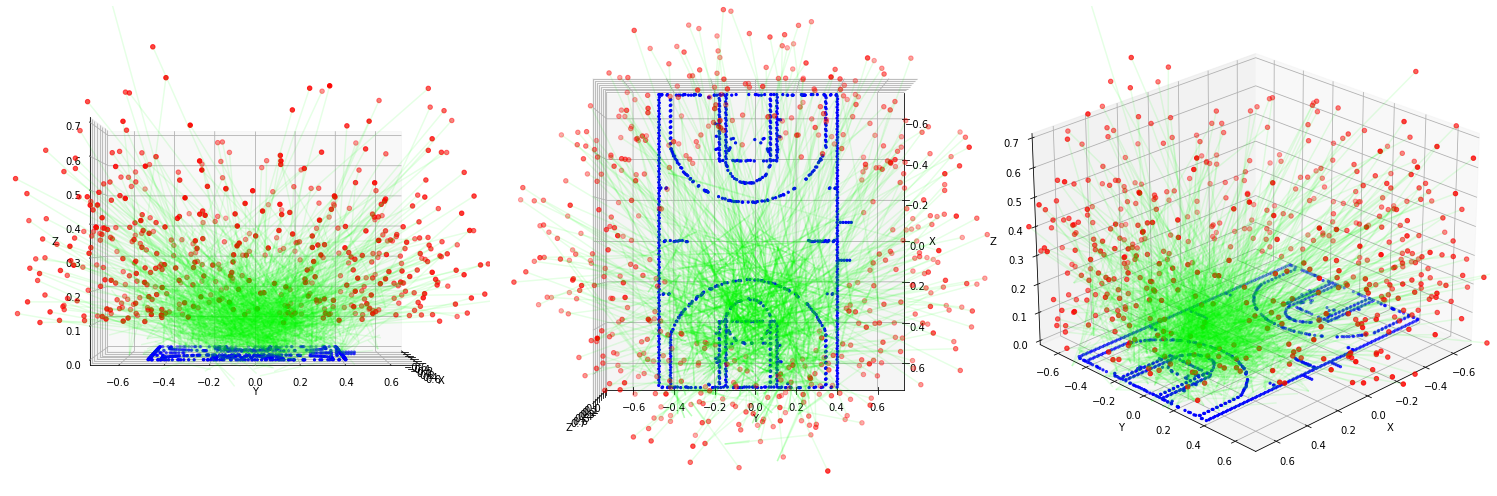

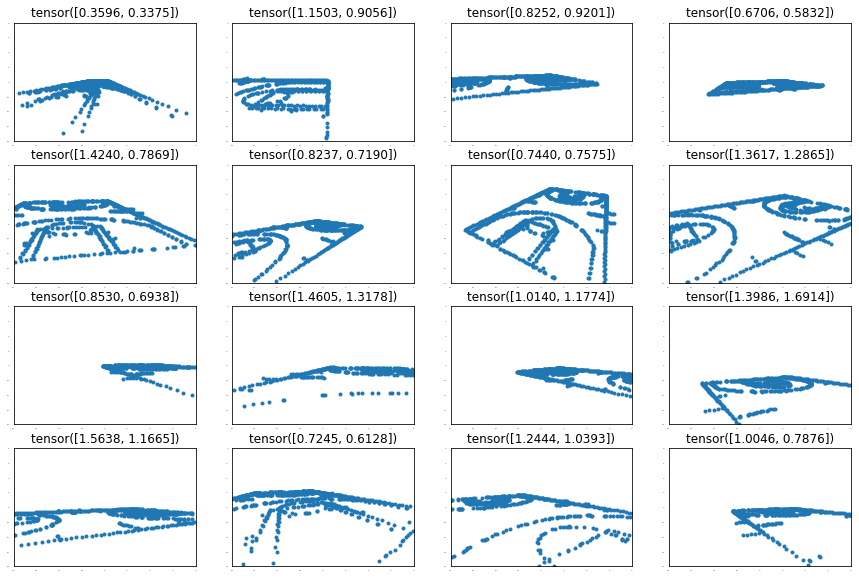

In [9]:
x = torch.distributions.MultivariateNormal(torch.zeros(8), torch.eye(8)).sample((1000,))
dofs_cams, pts_to = gaussian2cam(x)
fxy = cam.calc_fxy_ratio(dofs_cams[:, 6:])

plt.figure(figsize=(20,5))
plt.subplot(131);plt.scatter(*fxy.transpose(0,1), marker='.');plt.xlabel('fx');plt.ylabel('fy')
plt.subplot(132);plt.hist(fxy[..., 0].flatten().numpy(), bins=100);plt.title('fx histogram')
plt.subplot(133);plt.hist(fxy[..., 1].flatten().numpy(), bins=100);plt.title('fy histogram')
plt.show()

x = torch.distributions.MultivariateNormal(torch.zeros(8), torch.eye(8)).sample((500,))
dofs_cams, pts_to = gaussian2cam(x)

for ax in draw.multi_view(views_court, region_court)[0]:
    ax.scatter3D(*X_w[::10].transpose(0,1), marker='.', color='b')
    ax.scatter3D(*dofs_cams[:, :3].transpose(0,1), color='r')
    ax.quiver3D(*dofs_cams[:, :3].transpose(0,1), 
                *(pts_to-dofs_cams[:, :3]).transpose(0,1), color=[0., 1., 0., 0.1])
    
plt.figure(figsize=(15, 10))
for i in range(16):
    plt.subplot(4,4,i+1)
    dofs_cam = dofs_cams[i].clone()
    draw.show_cam_view(X_w[::10], dofs_cam, calc_fxy=cam.calc_fxy_ratio)
    plt.title(cam.calc_fxy_ratio(dofs_cam[6:]))


In [10]:
# dofs_cams, pts_to = generate_random_views(500)
# for ax in draw.multi_view(views_court, region_court)[0]:
#     ax.scatter3D(*X_w[::10].transpose(0,1), marker='.', color='b')
#     ax.scatter3D(*dofs_cams[:, :3].transpose(0,1), color='r')
#     ax.quiver3D(*dofs_cams[:, :3].transpose(0,1), 
#                 *(pts_to-dofs_cams[:, :3]).transpose(0,1), color=[0., 1., 0., 0.1])
    
# plt.figure(figsize=(15, 10))
# for i in range(16):
#     plt.subplot(4,4,i+1)
#     dofs_cam = dofs_cams[i].clone()
#     draw.show_cam_view(X_w[::10], dofs_cam)
#     plt.title(f'fx: {np.e**dofs_cam[6].item():1.2f}, fy: {np.e**dofs_cam[7].item():1.2f}')


In [147]:
x = torch.distributions.MultivariateNormal(torch.zeros(8), torch.eye(8)).sample()
dofs_cam, pts_to = gaussian2cam(x)

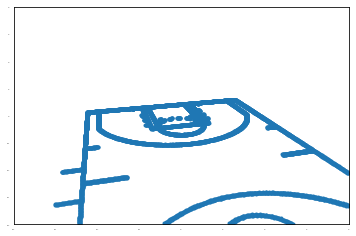

In [148]:
draw.show_cam_view(X_w, dofs_cam)

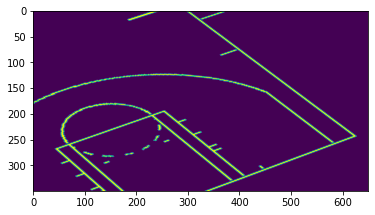

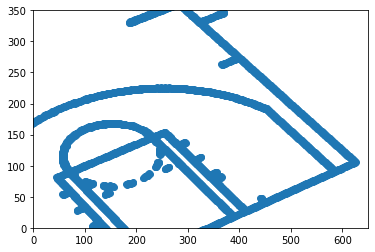

In [152]:
def temp(dofs_cam, X_w):
    R = util.so3_exponential_map(dofs_cam[..., 3:6]) # this goes from camera->world
    Rinv = R.transpose(-1, -2) # world->camera
    T = dofs_cam[..., :3]

    X_c = (Rinv @ ((X_w-T)[..., None]))[..., 0]

    dofs_f = dofs_cam[..., 6:]
    fxy = cam.calc_fxy_ratio(dofs_f)

    X_i = fxy * ((X_c/X_c[..., [-1]])[..., :2])

    vis_mask = torch.logical_and(X_i>=-1., X_i<=1).all(dim=-1)
    vis_mask = torch.logical_and(vis_mask, X_c[..., 2]>0.)
    return X_c, X_i, vis_mask


def show_warp(img, dofs_cam, calc_fxy=cam.calc_fxy_ratio):
    R = util.so3_exponential_map(dofs_cam[..., 3:6]) # this goes from camera->world
    Rinv = R.transpose(-1, -2) # world->camera
    T = dofs_cam[..., :3]
    
    dofs_f = dofs_cam[..., 6:]
    fxy = calc_fxy(dofs_f)
    fx, fy = fxy
    
    C = np.eye(4)
    C[:3, :3] = Rinv[:3, :3]
    C[:3, 3] = -Rinv@T
    
    P = np.eye(4)[:3, :]
    P[0, 0] = fx
    P[1, 1] = fy
    
    
    S = np.eye(3)
    S[0,0] = 1./scale
    S[1,1] = 1./scale
    S[0,2] = -binary.shape[1]/2./scale
    S[1,2] = -binary.shape[0]/2./scale
    
    X_2d_homo = (np.stack([X_court, Y_court, np.ones_like(X_court)], axis=-1)[..., None])

    X_c_true, X_i_true, vis_mask_true = temp(dofs_cam, X_w)   
    
#     M = P@C@np.eye(4)
#     X_i = (M @ (np.concatenate([X_w, np.ones((len(X_w),1))],axis=-1)[..., None]))[..., 0]    
#     X_i = X_i/X_i[:, [-1]]

    
    dsize = (650,350)
    Sback=np.array([[dsize[0]/2.,0,dsize[0]/2.],
                    [0,dsize[1]/2.,dsize[1]/2.],
                    [0,0,1]])  
    M = Sback@P@C[:, [0, 1, 3]]@S
    
    
    plt.imshow(np.flip(cv2.warpPerspective(img, M, dsize), axis=[0,1]))
    plt.show()

    
    M = Sback@P@C[:, [0, 1, 3]]@S
    X_i = (M @ X_2d_homo)
    X_i = X_i/X_i[:, [-1]]
    
    plt.scatter(dsize[0]-X_i[:, 0],X_i[:, 1])
#     plt.xlim(-1,1);plt.ylim(-1,1)
    plt.xlim(0,dsize[0]);plt.ylim(0,dsize[1])
    plt.show()
    
    
    
show_warp(gray, dofs_cam)


# Ad Hoc Comparison with real data

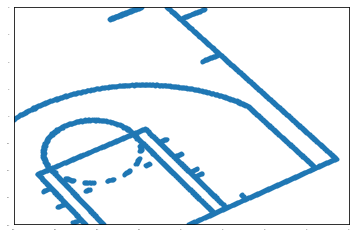

In [151]:
dofs_cam = cam.calc_dofs_cam(torch.tensor([.7, 0., 1.5]),torch.tensor([.4, .2, .0]), torch.tensor([1.4, 0.]))
draw.show_cam_view(X_w[::1], dofs_cam)

In [12]:
X_w_down = X_w[::10, :]

# Loss function

In [13]:
"""
alpha= 0.0 will take the mean.
alpha= 0.2 will be very close to max.
alpha=-0.2 will be very close to min.
"""
def smooth_max(x, alpha, dim=-1):
    # unstable version:
    # return (x*(alpha*x).exp()).sum()/((alpha*x).exp()).sum()
    return ((alpha*x).softmax(dim=dim)*x).sum(dim=dim)

def pt2pt_dist(p1, p2):
    # (..., N1, D) and (..., N2, D)
    return (p1[..., None, :]-p2[..., None, :, :]).norm(dim=-1).min(dim=-1).values

def pt2pt_dist_soft(p1, p2, alpha=-.2):
    # (..., N1, D) and (..., N2, D)
    return smooth_max((p1[..., None, :]-p2[..., None, :, :]).norm(dim=-1), alpha=alpha, dim=-1)

def fitness(dofs_cam, X_i_true):
    X_i, vis_mask = cam.project_to_cam(X_w_down, dofs_cam)
    X_i = X_i[vis_mask]
    if(X_i.shape[0]==0):
        return np.inf
    p = X_i.shape[0] / X_w_down.shape[0]
    loss_vis = -np.log(p)
    loss_pt2pt = pt2pt_dist(X_i, X_i_true).mean().item()
    loss_small_f = (-dofs_cam[..., 6]).exp().mean().item()
#     print(loss_vis, loss_pt2pt, loss_small_f)
    return loss_vis+loss_pt2pt+loss_small_f

# Energy Minimization with Population Based Search

In [14]:
import cma

In [11]:
torch.manual_seed(0)
x = torch.distributions.MultivariateNormal(torch.zeros(8), torch.eye(8)).sample()
# x[6] = 1.
# x[7] = 0.

dofs_cam_true, _ = gaussian2cam(x)

In [12]:
draw.show_cam_view(X_w_down, dofs_cam_true)

NameError: name 'X_w_down' is not defined

In [55]:
X_i_true, vis_mask = cam.project_to_cam(X_w_down, dofs_cam_true)
X_i_true = X_i_true[vis_mask]

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=645090, Thu Nov  5 01:05:07 2020)
0


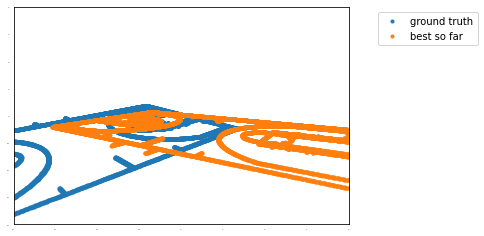

1


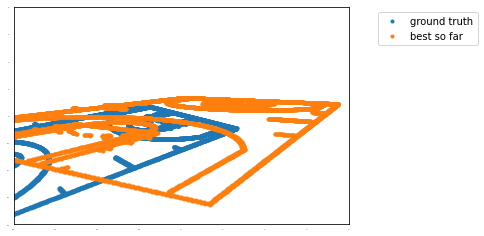

2


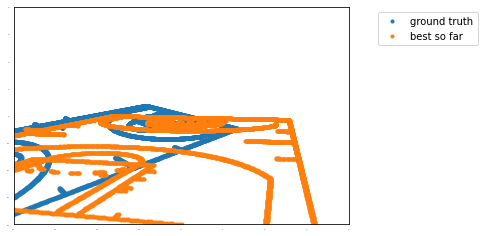

3


/home/akarshkumar0101/.local/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: function values with index [31] are not finite but [inf]. (class=CMAEvolutionStrategy method=ask iteration=3)
  warnings.warn(msg + ' (' +


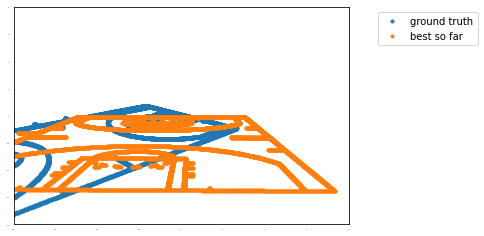

4


/home/akarshkumar0101/.local/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: function values with index [86] are not finite but [inf]. (class=CMAEvolutionStrategy method=ask iteration=4)
  warnings.warn(msg + ' (' +


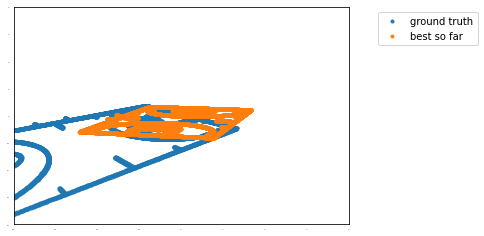

5


/home/akarshkumar0101/.local/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: function values with index [70] are not finite but [inf]. (class=CMAEvolutionStrategy method=ask iteration=5)
  warnings.warn(msg + ' (' +


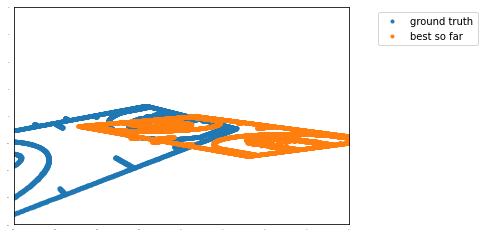

6


/home/akarshkumar0101/.local/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: function values with index [5, 77] are not finite but [inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=6)
  warnings.warn(msg + ' (' +


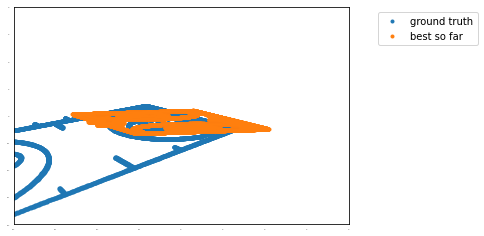

7


/home/akarshkumar0101/.local/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: function values with index [7, 8, 23, 42, 82] are not finite but [inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask iteration=7)
  warnings.warn(msg + ' (' +


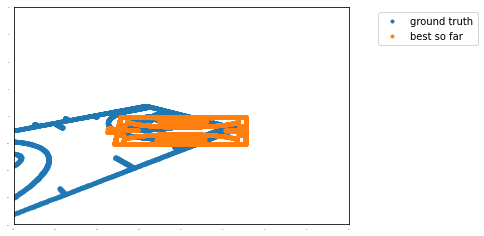

8


KeyboardInterrupt: 

In [57]:
es = cma.CMAEvolutionStrategy(8*[0], 1.0)
i = 0
while not es.stop():
    solutions = es.ask(100)
    print(i)
#     for x in solutions:
#         x[6] = 1.
#         x[7] = 0.
    fitnesses = [fitness(gaussian2cam(torch.tensor(x).float())[0], X_i_true) for x in solutions]
    es.tell(solutions, fitnesses)
#     es.logger.add()
#     es.disp()
    i+=1
    if i%1==0:
        draw.show_cam_view(X_w, dofs_cam_true, label='ground truth')
        draw.show_cam_view(X_w, gaussian2cam(torch.tensor(es.best.x).float())[0], label='best so far')
        plt.legend(bbox_to_anchor=(1.4, 1.))
        plt.show()

(array([  3.,  21.,  78., 158., 259., 218., 145.,  83.,  28.,   7.]),
 array([0.8755096, 1.4093974, 1.9432851, 2.4771729, 3.0110605, 3.5449483,
        4.078836 , 4.612724 , 5.1466117, 5.680499 , 6.214387 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

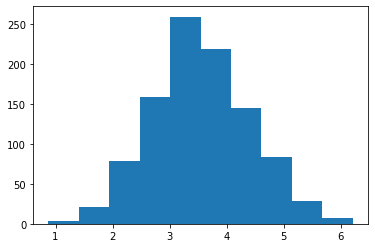

In [46]:
x_true = torch.distributions.MultivariateNormal(torch.zeros(8), torch.eye(8)).sample()
x = torch.distributions.MultivariateNormal(torch.zeros(8), torch.eye(8)).sample((1000,))


dists = (x-x_true).norm(dim=-1)
plt.hist(dists.numpy())

In [92]:
# es.result_pretty()
# cma.plot()

# Energy Minimization with Supervised Rendering Loss

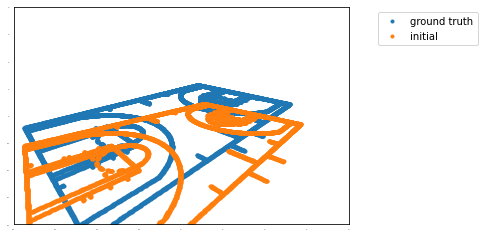

In [42]:
dofs_cam = cam.calc_dofs_cam(torch.tensor([.6,.6, 0.6]), 
                             torch.tensor([0., 0., 0.]), 
                             fxy=torch.tensor([0., 0.]))
dofs_cam_optim = dofs_cam.clone()
torch.manual_seed(10)
dofs_cam_optim = dofs_cam_optim + 0.1*torch.randn(dofs_cam_optim.shape)

draw.show_cam_view(X_w, dofs_cam, label='ground truth')
draw.show_cam_view(X_w, dofs_cam_optim, label='initial')
plt.legend(bbox_to_anchor=(1.4, 1.))

No handles with labels found to put in legend.


loss:  0.08055940270423889
pt2pt:  0.08055940270423889
tensor([0., 0.], grad_fn=<SliceBackward>)



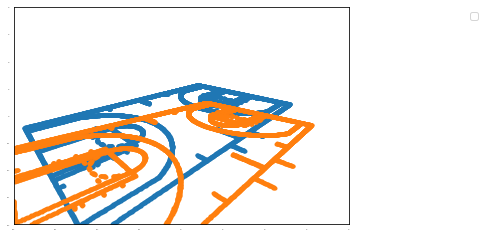

loss:  0.07483840733766556
pt2pt:  0.07483840733766556
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.06773365288972855
pt2pt:  0.06773365288972855
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.059148408472537994
pt2pt:  0.059148408472537994
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.049734748899936676
pt2pt:  0.049734748899936676
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.039606861770153046
pt2pt:  0.039606861770153046
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.027756936848163605
pt2pt:  0.027756936848163605
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.0199738759547472
pt2pt:  0.0199738759547472
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.02252376452088356
pt2pt:  0.02252376452088356
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.02725219912827015
pt2pt:  0.02725219912827015
tensor([0., 0.], grad_fn=<SliceBackward>)



No handles with labels found to put in legend.


loss:  0.028437091037631035
pt2pt:  0.028437091037631035
tensor([0., 0.], grad_fn=<SliceBackward>)



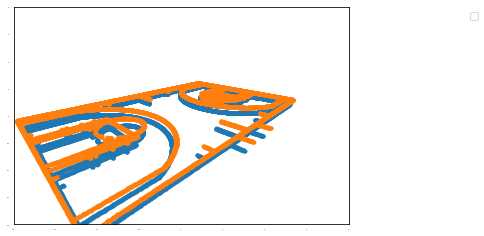

loss:  0.027513206005096436
pt2pt:  0.027513206005096436
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.025293534621596336
pt2pt:  0.025293534621596336
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.021743616089224815
pt2pt:  0.021743616089224815
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.019427817314863205
pt2pt:  0.019427817314863205
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.01913537085056305
pt2pt:  0.01913537085056305
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.01725642941892147
pt2pt:  0.01725642941892147
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.015615489333868027
pt2pt:  0.015615489333868027
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.013911217451095581
pt2pt:  0.013911217451095581
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.012031374499201775
pt2pt:  0.012031374499201775
tensor([0., 0.], grad_fn=<SliceBackward>)



No handles with labels found to put in legend.


loss:  0.013197838328778744
pt2pt:  0.013197838328778744
tensor([0., 0.], grad_fn=<SliceBackward>)



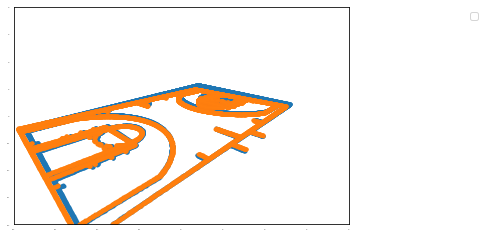

loss:  0.015548312105238438
pt2pt:  0.015548312105238438
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.01611088030040264
pt2pt:  0.01611088030040264
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.015160067938268185
pt2pt:  0.015160067938268185
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.013678614981472492
pt2pt:  0.013678614981472492
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.011612003669142723
pt2pt:  0.011612003669142723
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.010788671672344208
pt2pt:  0.010788671672344208
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.011268536560237408
pt2pt:  0.011268536560237408
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.011875171214342117
pt2pt:  0.011875171214342117
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.012426052242517471
pt2pt:  0.012426052242517471
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.012365964241325855
pt2pt:  0.012365964241325855
tensor([0., 0.], grad_fn=<SliceBackward>)



No handles with labels found to put in legend.


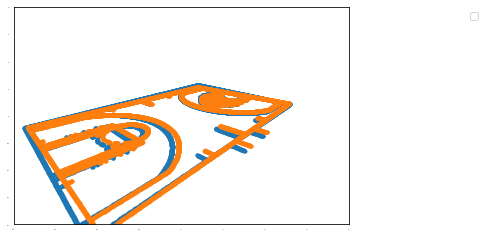

loss:  0.012100091204047203
pt2pt:  0.012100091204047203
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.011721956543624401
pt2pt:  0.011721956543624401
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.010988873429596424
pt2pt:  0.010988873429596424
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.009643420577049255
pt2pt:  0.009643420577049255
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.009015332907438278
pt2pt:  0.009015332907438278
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.008442345075309277
pt2pt:  0.008442345075309277
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.009208944626152515
pt2pt:  0.009208944626152515
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.009525120258331299
pt2pt:  0.009525120258331299
tensor([0., 0.], grad_fn=<SliceBackward>)

loss:  0.008969816379249096
pt2pt:  0.008969816379249096
tensor([0., 0.], grad_fn=<SliceBackward>)




In [43]:
dofs_cam_optim_p = dofs_cam_optim[:6]
opt = torch.optim.Adam([{'params': dofs_cam_optim_p, 'lr': 0.01}])
dofs_cam_optim_p.requires_grad_()

X_true, vis_mask = util.project_to_cam(X_w_down, dofs_cam)
X_true = X_true[vis_mask]

for i in tqdm(range(40)):
    dofs_cam_optim = torch.cat([dofs_cam_optim_p, torch.tensor([0., 0.])])
    
    
    X_i, vis_mask = util.project_to_cam(X_w_down, dofs_cam_optim)
    X_i = X_i[vis_mask]
    
#     loss = pt2pt_dist(X_i, X_true)
    loss1 = pt2pt_dist(X_i, X_true)
    loss2 = pt2pt_dist_soft(X_true, X_i)
    loss = (loss1).mean()#+(loss2*1000).pow(2).mean()
    print('loss: ', loss.item())
    print('pt2pt: ', pt2pt_dist(X_i, X_true).mean().item())
    print(dofs_cam_optim[6:])
    print()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if i%10==0:
        draw.show_cam_view(X_w, dofs_cam)
        draw.show_cam_view(X_w, dofs_cam_optim.detach())
        plt.legend(bbox_to_anchor=(1.4, 1.))
        plt.show()

In [44]:
dofs_cam

tensor([ 0.6000,  0.6000,  0.6000,  2.0521, -0.8500, -0.4400,  0.0000,  0.0000])

In [45]:
dofs_cam_optim

tensor([ 0.6291,  0.5964,  0.5605,  2.0042, -0.8577, -0.4736,  0.0000,  0.0000],
       grad_fn=<CatBackward>)

In [46]:
dofs_cam_optim = dofs_cam_optim.detach()

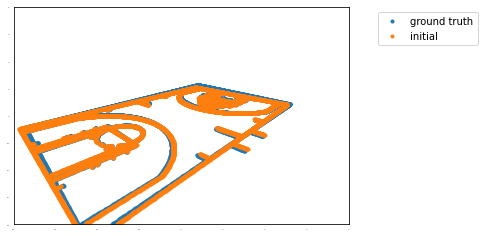

In [47]:
draw.show_cam_view(X_w, dofs_cam, label='ground truth')
draw.show_cam_view(X_w, dofs_cam_optim, label='initial')
plt.legend(bbox_to_anchor=(1.4, 1.))

In [ ]:
# a list of size V, each element is:
# a list of size N, each element is:
# Torch Tensor of size: (P, k, 2)



